# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 7  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

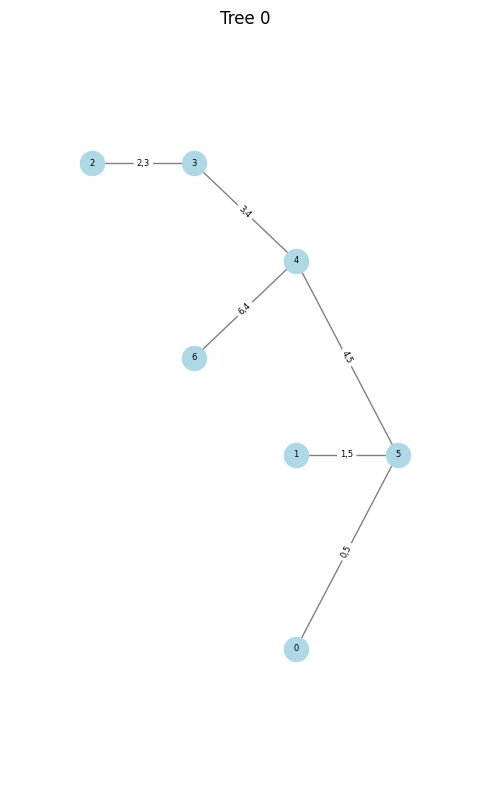

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-11 15:51:30,653] A new study created in RDB with name: no-name-8b0b571a-3dac-4941-ab18-4707c3eb38c8
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 4/2000 [00:00<02:31, 13.13it/s]

current_loss: tensor(1.4333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4356290102005005
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4331194162368774
current_loss: tensor(1.4281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.426094889640808
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.422878384590149
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:03, 16.08it/s]

current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4218127727508545
current_loss: tensor(1.4160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4220290184020996
current_loss: tensor(1.4158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4220765829086304
current_loss: tensor(1.4158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4220722913742065
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4222677946090698
current_loss: tensor(1.4157, 


  0%|          | 1/2000 [00:00<05:39,  5.89it/s]

current_loss: tensor(1.4180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.321414589881897
current_loss: tensor(1.3179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2051208019256592
current_loss: tensor(1.2115, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:51, 11.61it/s]

current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1604282855987549
current_loss: tensor(1.1688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1505942344665527
current_loss: tensor(1.1580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.136519432067871


  0%|          | 7/2000 [00:00<02:37, 12.65it/s]

current_loss: tensor(1.1426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1143529415130615
current_loss: tensor(1.1212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1021478176116943
current_loss: tensor(1.1087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0942591428756714


  1%|          | 11/2000 [00:00<02:26, 13.57it/s]

current_loss: tensor(1.1012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0893423557281494
current_loss: tensor(1.0966, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0743681192398071
current_loss: tensor(1.0826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.062680959701538


  1%|          | 13/2000 [00:01<02:23, 13.85it/s]

current_loss: tensor(1.0681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0516867637634277
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0481181144714355
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0435864925384521


  1%|          | 17/2000 [00:01<02:20, 14.13it/s]

current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0358457565307617
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0342910289764404
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0269440412521362


  1%|          | 19/2000 [00:01<02:19, 14.22it/s]

current_loss: tensor(1.0303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.025648593902588
current_loss: tensor(1.0274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0237667560577393
current_loss: tensor(1.0255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0217458009719849


  1%|          | 23/2000 [00:01<02:17, 14.35it/s]

current_loss: tensor(1.0236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0180211067199707
current_loss: tensor(1.0187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0189658403396606
current_loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0141680240631104


  1%|▏         | 25/2000 [00:01<02:17, 14.35it/s]

current_loss: tensor(1.0121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.012774109840393
current_loss: tensor(1.0110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0068341493606567
current_loss: tensor(1.0067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0076477527618408


  1%|▏         | 29/2000 [00:02<02:16, 14.42it/s]

current_loss: tensor(1.0055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0068063735961914
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.005993127822876
current_loss: tensor(1.0038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0048264265060425


  2%|▏         | 31/2000 [00:02<02:16, 14.38it/s]

current_loss: tensor(1.0026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0043635368347168
current_loss: tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.003132700920105
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9986388087272644


  2%|▏         | 35/2000 [00:02<02:16, 14.41it/s]

current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9976240396499634
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9960973858833313
current_loss: tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9950284957885742


  2%|▏         | 37/2000 [00:02<02:16, 14.38it/s]

current_loss: tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9919437766075134
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9894508123397827
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9913802742958069


  2%|▏         | 41/2000 [00:02<02:15, 14.41it/s]

current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.988386869430542
current_loss: tensor(0.9879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9870535731315613
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9867017865180969


  2%|▏         | 43/2000 [00:03<02:22, 13.69it/s]

current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9864673614501953
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9863864183425903
current_loss: tensor(0.9851, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:28, 13.15it/s]

current_loss: tensor(0.9844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9862090945243835
current_loss: tensor(0.9844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9860761761665344
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9865948557853699
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:21, 13.79it/s]

current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.986097514629364
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.98573899269104
current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9847979545593262
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:19, 13.97it/s]

current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9844081997871399
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9848319292068481
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.983741044998169
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:03<02:18, 14.09it/s]

current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9832582473754883
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.982559859752655
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9821724891662598
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:16, 14.19it/s]

current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9826778769493103
current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.982256293296814
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9820435047149658
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:16, 14.18it/s]

current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9819038510322571
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9817439317703247
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9812922477722168
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:04<02:16, 14.23it/s]

current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9811072945594788
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9810086488723755
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9807284474372864
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:04<02:16, 14.14it/s]

current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9806214570999146
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9805862903594971
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9804723858833313
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:04<02:18, 13.93it/s]

current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9803787469863892
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9802634716033936
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9798983335494995
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:15, 14.22it/s]

current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9795517325401306
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9783908724784851
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9777340888977051
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:05<02:14, 14.31it/s]

current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9771854877471924
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9769169688224792
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9768462777137756
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:05<02:13, 14.43it/s]

current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9768524169921875
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9768540859222412
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9767972230911255
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:05<02:12, 14.44it/s]

current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9764016270637512
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9758599400520325
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748571515083313
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 85/2000 [00:06<02:14, 14.22it/s]

current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736848473548889
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9713277816772461
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680852293968201
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 87/2000 [00:06<02:14, 14.23it/s]

current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671902656555176
current_loss: tensor(0.9653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9669395685195923
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9663093090057373
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 91/2000 [00:06<02:13, 14.32it/s]

current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676914215087891
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665766954421997
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656789898872375
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:06<02:13, 14.32it/s]

current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654557704925537
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.964995265007019
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9648023843765259


  5%|▍         | 97/2000 [00:06<02:17, 13.87it/s]

current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9649137854576111
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.964783251285553
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642113447189331


  5%|▍         | 99/2000 [00:07<02:22, 13.36it/s]

current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642282724380493
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642506837844849
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 101/2000 [00:07<02:19, 13.65it/s]

current_loss_val:  0.9642841815948486
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9638696908950806
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635788798332214
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 105/2000 [00:07<02:15, 14.01it/s]

current_loss_val:  0.963319718837738
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9632859230041504
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.963201105594635
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 107/2000 [00:07<02:21, 13.40it/s]

current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9629393219947815
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9628280997276306
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.962678849697113
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 111/2000 [00:07<02:15, 13.91it/s]

current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636552333831787
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631401896476746
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9627574682235718
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 113/2000 [00:08<02:14, 14.04it/s]

current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626843929290771
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623984098434448
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9628132581710815
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 117/2000 [00:08<02:12, 14.23it/s]

current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9626408815383911
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9624596238136292
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.962193489074707
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 119/2000 [00:08<02:18, 13.54it/s]

current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9617316722869873
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960905909538269
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605136513710022


  6%|▌         | 123/2000 [00:08<02:14, 13.93it/s]

current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598327279090881
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594109654426575
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9593157768249512


  6%|▋         | 125/2000 [00:08<02:14, 13.97it/s]

current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9592597484588623
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95911705493927
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589553475379944


  6%|▋         | 129/2000 [00:09<02:12, 14.17it/s]

current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584445357322693
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584776759147644
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585208892822266


  7%|▋         | 131/2000 [00:09<02:11, 14.24it/s]

current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586023688316345
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581799507141113
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577248692512512


  7%|▋         | 135/2000 [00:09<02:10, 14.30it/s]

current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576894640922546
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577133059501648
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577575325965881


  7%|▋         | 137/2000 [00:09<02:10, 14.32it/s]

current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956890344619751
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569416642189026
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569990038871765


  7%|▋         | 140/2000 [00:10<02:14, 13.86it/s]

current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95707768201828
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571583271026611
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572064876556396
Early Stop at iteration 140 with minimal loss tensor(0.9569, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 15:51:43,437] Trial 0 finished with value: -6.6982316970825195 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.2399532844914467, 'penalty_decorrelation_ridge_second_difference': 5.124509307618611}. Best is trial 0 with value: -6.6982316970825195.
  0%|          | 2/2000 [00:00<02:44, 12.12it/s]

current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569889903068542
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571213722229004
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586197137832642


  0%|          | 4/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9597362279891968
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598341584205627
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:27,  7.47it/s]


current_loss_val:  0.9596788883209229
Early Stop at iteration 5 with minimal loss tensor(0.9570, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:51:44,699] Trial 1 finished with value: -6.698922634124756 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.139493714217616, 'penalty_decorrelation_ridge_second_difference': 6.747627737900128}. Best is trial 0 with value: -6.6982316970825195.
  0%|          | 2/2000 [00:00<02:47, 11.94it/s]

current_loss: tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572526216506958
current_loss: tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574790596961975
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9844, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:45, 12.08it/s]

current_loss_val:  0.9591090679168701
current_loss: tensor(0.9844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585099816322327
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958755612373352
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:08, 10.59it/s]


current_loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594094753265381
Early Stop at iteration 5 with minimal loss tensor(0.9573, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:51:45,957] Trial 2 finished with value: -6.70076847076416 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.254845160865102, 'penalty_decorrelation_ridge_second_difference': 18.37746454691541}. Best is trial 0 with value: -6.6982316970825195.
  0%|          | 2/2000 [00:00<02:24, 13.81it/s]

current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582130312919617
current_loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578663110733032
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584903120994568


  0%|          | 4/2000 [00:00<02:20, 14.18it/s]

current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588522911071777
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585403800010681
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:01, 10.99it/s]

current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958652138710022
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9627160429954529
Early Stop at iteration 6 with minimal loss tensor(0.9579, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 15:51:47,164] Trial 3 finished with value: -6.705063819885254 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.858838392798898, 'penalty_decorrelation_ridge_second_difference': 23.082751809109055}. Best is trial 0 with value: -6.6982316970825195.
  0%|          | 2/2000 [00:00<03:10, 10.52it/s]

current_loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570362567901611
current_loss: tensor(0.9946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.959540843963623
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.46it/s]

current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9596191048622131
current_loss: tensor(0.9917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9625276923179626
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654101729393005
current_loss: tensor(0.9866, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:09, 10.53it/s]


current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636521935462952
Early Stop at iteration 5 with minimal loss tensor(0.9570, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:51:48,317] Trial 4 finished with value: -6.699254035949707 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.57981579708705, 'penalty_decorrelation_ridge_second_difference': 3.7704596722521493}. Best is trial 0 with value: -6.6982316970825195.
  0%|          | 2/2000 [00:00<02:54, 11.47it/s]

current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569990038871765
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571375250816345
current_loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:34, 12.90it/s]

current_loss_val:  0.9589532017707825
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9610021710395813
current_loss: tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961245059967041
current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:12, 10.38it/s]


current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9610062837600708
Early Stop at iteration 5 with minimal loss tensor(0.9570, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:51:49,522] Trial 5 finished with value: -6.698992729187012 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.668914980717187, 'penalty_decorrelation_ridge_second_difference': 2.3790667324434716}. Best is trial 0 with value: -6.6982316970825195.
  0%|          | 2/2000 [00:00<02:21, 14.08it/s]

current_loss: tensor(1.0246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582756161689758
current_loss: tensor(1.0239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957907497882843
current_loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958730936050415


  0%|          | 4/2000 [00:00<02:19, 14.29it/s]

current_loss: tensor(1.0199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9599431157112122
current_loss: tensor(1.0167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9635763764381409


  0%|          | 6/2000 [00:00<03:07, 10.66it/s]

current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9660243988037109
current_loss: tensor(1.0066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665281772613525
Early Stop at iteration 6 with minimal loss tensor(0.9579, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 15:51:50,742] Trial 6 finished with value: -6.705353260040283 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.69648537286186, 'penalty_decorrelation_ridge_second_difference': 7.360749263773519}. Best is trial 0 with value: -6.6982316970825195.
  0%|          | 2/2000 [00:00<02:46, 12.02it/s]

current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569048881530762
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569785594940186
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.15it/s]

current_loss_val:  0.9571648836135864
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570635557174683
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566007256507874
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.11it/s]

current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956323504447937
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562684893608093
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563524723052979
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:27, 13.48it/s]

current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559686779975891
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558179378509521
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558282494544983
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:23, 13.85it/s]

current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955713152885437
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556982517242432
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555361270904541
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:29, 13.24it/s]

current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548282623291016
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9545623660087585
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:41, 12.24it/s]

current_loss_val:  0.9539274573326111
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9531851410865784
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530665874481201
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:32, 12.94it/s]

current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953070878982544
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9531136155128479
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532185792922974
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:39, 12.36it/s]


current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530723690986633
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9531885385513306
Early Stop at iteration 23 with minimal loss tensor(0.9531, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:51:53,287] Trial 7 finished with value: -6.671466827392578 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1208177490326199, 'penalty_decorrelation_ridge_second_difference': 3.5106715124443224}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:44, 12.11it/s]

current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572276473045349
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574369192123413
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:49, 11.77it/s]

current_loss_val:  0.9583895206451416
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579023122787476
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581226706504822
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:11, 10.41it/s]


current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588061571121216
Early Stop at iteration 5 with minimal loss tensor(0.9572, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:51:54,401] Trial 8 finished with value: -6.700593948364258 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.83635644090889, 'penalty_decorrelation_ridge_second_difference': 21.992048855575476}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:26, 13.61it/s]

current_loss: tensor(1.0239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576073884963989
current_loss: tensor(1.0218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9591453075408936
current_loss: tensor(1.0178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0131, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.65it/s]

current_loss_val:  0.9600662589073181
current_loss: tensor(1.0131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594882726669312
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9606986045837402
current_loss: tensor(1.0072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:00, 11.03it/s]


current_loss_val:  0.9637641310691833
Early Stop at iteration 5 with minimal loss tensor(0.9576, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:51:55,512] Trial 9 finished with value: -6.703251838684082 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.341732160786815, 'penalty_decorrelation_ridge_second_difference': 29.679622406244594}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 1/2000 [00:00<03:20,  9.97it/s]

current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570993185043335
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572759866714478
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:39, 12.51it/s]

current_loss_val:  0.958762526512146
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580719470977783
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582573771476746
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:10, 10.49it/s]


current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584183692932129
Early Stop at iteration 5 with minimal loss tensor(0.9571, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:51:56,591] Trial 10 finished with value: -6.699695587158203 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.63859003922603, 'penalty_decorrelation_ridge_second_difference': 16.55637129555907}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 1/2000 [00:00<04:25,  7.52it/s]

current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569093585014343
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569849967956543


  0%|          | 3/2000 [00:00<02:55, 11.41it/s]

current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572487473487854
current_loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571471810340881
current_loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:39, 12.52it/s]

current_loss_val:  0.9565015435218811
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561275243759155
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561015367507935
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:40, 12.38it/s]

current_loss_val:  0.9571473598480225
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569247364997864
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567252993583679
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:54, 11.38it/s]

current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566249847412109
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561792016029358
Early Stop at iteration 11 with minimal loss tensor(0.9561, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 15:51:58,118] Trial 11 finished with value: -6.692710876464844 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.6048189932763897, 'penalty_decorrelation_ridge_second_difference': 1.0411769983445054}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:23, 13.94it/s]

current_loss: tensor(1.0030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958334743976593
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577894806861877
current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579112529754639


  0%|          | 6/2000 [00:00<02:17, 14.47it/s]

current_loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581785202026367
current_loss: tensor(0.9984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9629594683647156
current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605175852775574


  0%|          | 6/2000 [00:00<02:43, 12.22it/s]


current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605438113212585
Early Stop at iteration 6 with minimal loss tensor(0.9578, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:51:59,330] Trial 12 finished with value: -6.704526424407959 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.785733497039494, 'penalty_decorrelation_ridge_second_difference': 18.69089791642166}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:23, 13.93it/s]

current_loss: tensor(1.0223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579789638519287
current_loss: tensor(1.0210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583187699317932
current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615380764007568


  0%|          | 4/2000 [00:00<02:36, 12.73it/s]

current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961462140083313
current_loss: tensor(1.0066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9617036581039429
current_loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:00, 11.07it/s]


current_loss_val:  0.9638575911521912
Early Stop at iteration 5 with minimal loss tensor(0.9580, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:00,425] Trial 13 finished with value: -6.705853462219238 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.424576508460373, 'penalty_decorrelation_ridge_second_difference': 17.129484845238675}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:21, 14.10it/s]

current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585140943527222
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575925469398499
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573528170585632


  0%|          | 4/2000 [00:00<02:20, 14.20it/s]

current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572997093200684
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572067260742188
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:28, 13.41it/s]

current_loss_val:  0.9586977958679199
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9596526026725769
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9593474268913269
current_loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:42, 12.23it/s]


current_loss_val:  0.9587952494621277
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9595184326171875
Early Stop at iteration 9 with minimal loss tensor(0.9572, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:01,746] Trial 14 finished with value: -6.700447082519531 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.393367464366997, 'penalty_decorrelation_ridge_second_difference': 24.669360172740518}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:48, 11.88it/s]

current_loss: tensor(0.9551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569387435913086
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570374488830566
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:32, 13.07it/s]

current_loss_val:  0.9575782418251038
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957325279712677
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572536945343018
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:22,  9.86it/s]


current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570662379264832
Early Stop at iteration 5 with minimal loss tensor(0.9569, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:02,827] Trial 15 finished with value: -6.69857120513916 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7845241547913555, 'penalty_decorrelation_ridge_second_difference': 13.671556921973446}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:47, 11.93it/s]

current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569140672683716
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569911956787109
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:48, 11.83it/s]

current_loss_val:  0.9573381543159485
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572667479515076
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564865231513977
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:35, 12.82it/s]

current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560686349868774
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561188220977783
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.959381103515625
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:42, 12.28it/s]

current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590340256690979
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9587357044219971
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:56, 11.24it/s]


current_loss_val:  0.9584141969680786
Early Stop at iteration 10 with minimal loss tensor(0.9561, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:04,346] Trial 16 finished with value: -6.692480564117432 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.536017932471387, 'penalty_decorrelation_ridge_second_difference': 0.44331934985932664}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 1/2000 [00:00<03:44,  8.89it/s]

current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569170475006104
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570026397705078
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:43, 12.22it/s]

current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573171138763428
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574283957481384
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570911526679993


  0%|          | 5/2000 [00:00<03:16, 10.17it/s]


current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569491147994995
Early Stop at iteration 5 with minimal loss tensor(0.9569, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:05,440] Trial 17 finished with value: -6.69842004776001 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.486807896486232, 'penalty_decorrelation_ridge_second_difference': 0.21848876633868697}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:45, 12.04it/s]

current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569169878959656
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957001805305481
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:32, 13.12it/s]

current_loss_val:  0.9573131799697876
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572847485542297
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570432305335999
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.16it/s]

current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568462371826172
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568036794662476
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569752216339111
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:35, 12.78it/s]

current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573619961738586
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95737224817276
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573175311088562


  1%|          | 11/2000 [00:00<02:47, 11.89it/s]


current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573962688446045
Early Stop at iteration 11 with minimal loss tensor(0.9568, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:06,941] Trial 18 finished with value: -6.697626113891602 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.6660235421229455, 'penalty_decorrelation_ridge_second_difference': 9.962994215850355}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:47, 11.90it/s]

current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569563865661621
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570691585540771
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.15it/s]

current_loss_val:  0.9579823613166809
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584169983863831
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583483338356018
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:09, 10.54it/s]


current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581629633903503
Early Stop at iteration 5 with minimal loss tensor(0.9570, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:08,019] Trial 19 finished with value: -6.698694229125977 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.604128294360457, 'penalty_decorrelation_ridge_second_difference': 8.559210981451107}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:45, 12.07it/s]

current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569084644317627
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569857716560364
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:29, 13.34it/s]

current_loss_val:  0.9572046399116516
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571563601493835
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567304849624634
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 8/2000 [00:00<02:34, 12.92it/s]

tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95648592710495
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564871788024902
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570863246917725
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:51, 11.62it/s]

current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956912100315094
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567790031433105
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567642211914062
Early Stop at iteration 10 with minimal loss tensor(0.9565, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 15:52:09,475] Trial 20 finished with value: -6.695401668548584 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.699099017804578, 'penalty_decorrelation_ridge_second_difference': 0.2466975139584875}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 1/2000 [00:00<03:24,  9.77it/s]

current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569125175476074
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569894671440125
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:41, 12.33it/s]

current_loss_val:  0.9573071002960205
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572328925132751
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564993381500244
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:33, 13.01it/s]

current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561032056808472
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956132709980011
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586958885192871
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:50, 11.64it/s]

current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583715796470642
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580977559089661
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578346014022827
Early Stop at iteration 10 with minimal loss tensor(0.9561, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 15:52:10,925] Trial 21 finished with value: -6.692722797393799 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.6271922039981421, 'penalty_decorrelation_ridge_second_difference': 0.14379669026574704}. Best is trial 7 with value: -6.671466827392578.
  0%|          | 2/2000 [00:00<02:47, 11.89it/s]

current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569042921066284
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569782018661499
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.15it/s]

current_loss_val:  0.9571463465690613
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570643901824951
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566863775253296
current_loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.12it/s]

current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564602375030518
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956415057182312
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564091563224792
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:36, 12.71it/s]

current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559071660041809
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559532403945923
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559139609336853


  1%|          | 14/2000 [00:01<02:27, 13.44it/s]

current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955786406993866
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555732607841492
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552621245384216


  1%|          | 16/2000 [00:01<02:25, 13.64it/s]

current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550517201423645
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549404978752136
current_loss: tensor(0.9420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954505443572998


  1%|          | 18/2000 [00:01<02:32, 12.96it/s]

current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538676738739014
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536150097846985
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:34, 12.82it/s]

current_loss_val:  0.9532400369644165
current_loss: tensor(0.9403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528814554214478
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525995254516602
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:29, 13.26it/s]

current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9521493911743164
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517395496368408
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515991806983948
current_loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:21, 13.89it/s]

current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514676332473755
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515253901481628
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516064524650574
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:33, 12.82it/s]

current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516588449478149
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516905546188354
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516966938972473
Early Stop at iteration 30 with minimal loss tensor(0.9515, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 15:52:13,914] Trial 22 finished with value: -6.66027307510376 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5870713405211381, 'penalty_decorrelation_ridge_second_difference': 5.707813145212306}. Best is trial 22 with value: -6.66027307510376.
  0%|          | 2/2000 [00:00<02:47, 11.92it/s]

current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569063782691956
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569822549819946
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:30, 13.27it/s]

current_loss_val:  0.957169234752655
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571022391319275
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567598700523376
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:33, 12.96it/s]

current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565466046333313
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565148949623108
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565731883049011
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.59it/s]

current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563250541687012
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563207030296326
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562789797782898


  1%|          | 14/2000 [00:01<02:29, 13.27it/s]

current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562139511108398
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559574127197266
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556549191474915


  1%|          | 16/2000 [00:01<02:26, 13.51it/s]

current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548802971839905
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541642069816589
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:33, 12.92it/s]

current_loss_val:  0.9537736773490906
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536298513412476
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9531781673431396
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:27, 13.46it/s]

current_loss_val:  0.9528316855430603
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529431462287903
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526610970497131
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:25, 13.62it/s]

current_loss_val:  0.9525651335716248
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952422022819519
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522395133972168
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:22, 13.82it/s]

current_loss_val:  0.9522110223770142
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523097276687622
current_loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9521456360816956
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:29, 13.21it/s]

current_loss_val:  0.9518442749977112
current_loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517917633056641
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9519144296646118


  2%|▏         | 34/2000 [00:02<02:30, 13.10it/s]

current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516461491584778
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516668319702148
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951653003692627


  2%|▏         | 36/2000 [00:02<02:26, 13.42it/s]

current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516748189926147
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517318606376648
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951575756072998


  2%|▏         | 40/2000 [00:03<02:23, 13.68it/s]

current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516271352767944
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951676070690155
current_loss: tensor(0.9383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517835378646851


  2%|▏         | 42/2000 [00:03<02:29, 13.14it/s]

current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518466591835022
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514765739440918
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:27, 13.30it/s]

current_loss_val:  0.951405942440033
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514369368553162
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515422582626343
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:31, 12.93it/s]

current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516602754592896
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517336487770081
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518162608146667
Early Stop at iteration 47 with minimal loss tensor(0.9514, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-11 15:52:18,129] Trial 23 finished with value: -6.659842014312744 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.12594790113215215, 'penalty_decorrelation_ridge_second_difference': 7.727669530689154}. Best is trial 23 with value: -6.659842014312744.
  0%|          | 1/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569257497787476
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570175409317017
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:01,  8.27it/s]

current_loss_val:  0.9574496746063232
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575284719467163
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573099613189697
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:38,  7.16it/s]


current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571051597595215
Early Stop at iteration 5 with minimal loss tensor(0.9569, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:19,456] Trial 24 finished with value: -6.698480606079102 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.677189765075844, 'penalty_decorrelation_ridge_second_difference': 9.245573139117385}. Best is trial 23 with value: -6.659842014312744.
  0%|          | 1/2000 [00:00<03:54,  8.51it/s]

current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569088220596313
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569871425628662
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<02:46, 11.98it/s]

current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571977853775024
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571504592895508
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568472504615784


  0%|          | 7/2000 [00:00<02:37, 12.62it/s]

current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566488862037659
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566304087638855
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567790031433105


  1%|          | 11/2000 [00:00<02:27, 13.51it/s]

current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568092823028564
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568756818771362
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566860198974609


  1%|          | 11/2000 [00:00<02:48, 11.80it/s]


current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566372036933899
Early Stop at iteration 11 with minimal loss tensor(0.9566, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:21,001] Trial 25 finished with value: -6.696413040161133 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9286100355114115, 'penalty_decorrelation_ridge_second_difference': 8.306143583850314}. Best is trial 23 with value: -6.659842014312744.
  0%|          | 1/2000 [00:00<03:20,  9.95it/s]

current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569768309593201
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570959806442261
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:29, 13.33it/s]

current_loss_val:  0.9578427672386169
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571961164474487
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574461579322815
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:02, 10.91it/s]


current_loss_val:  0.9573323130607605
Early Stop at iteration 5 with minimal loss tensor(0.9570, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:22,088] Trial 26 finished with value: -6.698837757110596 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.40229604662686147, 'penalty_decorrelation_ridge_second_difference': 17.044220918823573}. Best is trial 23 with value: -6.659842014312744.
  0%|          | 2/2000 [00:00<03:01, 11.00it/s]

current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569478034973145
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570549726486206
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:36, 12.76it/s]

current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578269720077515
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581407308578491
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580294489860535


  0%|          | 5/2000 [00:00<03:16, 10.17it/s]


current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578343629837036
Early Stop at iteration 5 with minimal loss tensor(0.9569, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:23,210] Trial 27 finished with value: -6.698634624481201 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.337346835173678, 'penalty_decorrelation_ridge_second_difference': 8.871391032648972}. Best is trial 23 with value: -6.659842014312744.
  0%|          | 1/2000 [00:00<03:20,  9.96it/s]

current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956908106803894
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569857716560364
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:50, 11.68it/s]

current_loss_val:  0.9571910500526428
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571338891983032
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568167924880981


  0%|          | 7/2000 [00:00<02:39, 12.49it/s]

current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566093683242798
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565820097923279
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566784501075745


  1%|          | 11/2000 [00:00<02:29, 13.30it/s]

current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566850662231445
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566733837127686
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564857482910156


  1%|          | 13/2000 [00:01<02:26, 13.52it/s]

current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956457257270813
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564321637153625
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563388824462891


  1%|          | 15/2000 [00:01<02:26, 13.57it/s]

current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549338221549988
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544510245323181
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:29, 13.24it/s]

current_loss_val:  0.9544252157211304
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9542814493179321
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532814621925354
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:44, 12.05it/s]

current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528099894523621
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526621103286743
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9524497389793396


  1%|          | 23/2000 [00:01<02:38, 12.49it/s]

current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514630436897278
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952864408493042
current_loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:29, 13.16it/s]

current_loss_val:  0.9522660374641418
current_loss: tensor(0.9398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9519387483596802
current_loss: tensor(0.9397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512776136398315
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:27, 13.40it/s]

current_loss_val:  0.9510298371315002
current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511241316795349
current_loss: tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512952566146851
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:28, 13.20it/s]

current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9512830376625061
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9509786367416382
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505826234817505
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:26, 13.42it/s]

current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505615234375
current_loss: tensor(0.9371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505438208580017
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504178166389465
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:24, 13.62it/s]

current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503620266914368
current_loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9501891136169434
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504739046096802
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:21, 13.86it/s]

current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505137801170349
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504840970039368
current_loss: tensor(0.9364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503201842308044
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:33, 12.74it/s]


current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9502140879631042
Early Stop at iteration 42 with minimal loss tensor(0.9502, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:27,102] Trial 28 finished with value: -6.6513237953186035 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.3160054519664961, 'penalty_decorrelation_ridge_second_difference': 8.429590527314213}. Best is trial 28 with value: -6.6513237953186035.
  0%|          | 2/2000 [00:00<02:49, 11.81it/s]

current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956914484500885
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569969773292542
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:30, 13.24it/s]

current_loss_val:  0.9572787284851074
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95721834897995
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569624066352844
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.24it/s]

current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.956758975982666
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566972851753235
current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567815661430359
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.90it/s]

current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957151472568512
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957170307636261
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571106433868408


  1%|          | 11/2000 [00:00<02:45, 12.00it/s]


current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570591449737549
Early Stop at iteration 11 with minimal loss tensor(0.9567, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-11 15:52:28,615] Trial 29 finished with value: -6.69688081741333 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.2556251703288255, 'penalty_decorrelation_ridge_second_difference': 10.325792585159448}. Best is trial 28 with value: -6.6513237953186035.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 4/1000 [00:00<00:25, 39.37it/s]

current_loss: tensor(1.4333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:25, 38.78it/s]

current_loss: tensor(1.4179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  1%|          | 12/1000 [00:00<00:28, 34.64it/s]

current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:00<00:26, 37.69it/s]

current_loss: tensor(1.4156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:00<00:25, 38.27it/s]

current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:00<00:25, 38.13it/s]

current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:00<00:24, 39.55it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:00<00:24, 39.11it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:01<00:23, 41.08it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:22, 42.53it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▌         | 50/1000 [00:01<00:21, 43.31it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:01<00:21, 43.16it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:01<00:22, 41.13it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:01<00:23, 40.29it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 70/1000 [00:01<00:22, 40.84it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 75/1000 [00:01<00:23, 39.79it/s]

current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:01<00:22, 40.52it/s]

current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:02<00:24, 37.18it/s]

current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:02<00:23, 39.18it/s]

current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 94/1000 [00:02<00:45, 19.81it/s]

current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 104/1000 [00:02<00:33, 27.13it/s]

current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█▏        | 114/1000 [00:03<00:25, 34.27it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 119/1000 [00:03<00:45, 19.36it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 129/1000 [00:03<00:32, 26.92it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 13%|█▎        | 133/1000 [00:04<00:29, 29.14it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 14%|█▍        | 138/1000 [00:04<00:26, 32.36it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 142/1000 [00:04<00:35, 24.33it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 146/1000 [00:04<00:41, 20.41it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 16%|█▌        | 155/1000 [00:05<00:34, 24.21it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 16%|█▌        | 158/1000 [00:05<00:48, 17.30it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 16%|█▌        | 159/1000 [00:05<00:29, 28.32it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

In [16]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<01:54,  8.72it/s]

current_loss: tensor(1.4168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.318264126777649
current_loss: tensor(1.3141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1916143894195557
current_loss: tensor(1.1921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:18, 12.61it/s]

current_loss: tensor(1.1507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1458702087402344
current_loss: tensor(1.1507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1368464231491089
current_loss: tensor(1.1410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1148922443389893
current_loss: tensor(1.1182, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:14, 13.32it/s]

current_loss: tensor(1.1075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.10213303565979
current_loss: tensor(1.1075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0947405099868774
current_loss: tensor(1.0973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.091253399848938
current_loss: tensor(1.0931, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<01:10, 14.00it/s]

current_loss: tensor(1.0872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0855026245117188
current_loss: tensor(1.0872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0721911191940308
current_loss: tensor(1.0743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0649057626724243
current_loss: tensor(1.0651, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<01:10, 14.07it/s]

current_loss: tensor(1.0545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0551159381866455
current_loss: tensor(1.0545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.052844524383545
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0496147871017456
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:01<01:09, 14.22it/s]

current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0456233024597168
current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0411691665649414
current_loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0387108325958252
current_loss: tensor(1.0366, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:01<01:08, 14.27it/s]

current_loss: tensor(1.0322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0344069004058838
current_loss: tensor(1.0322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0298089981079102
current_loss: tensor(1.0275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0264934301376343
current_loss: tensor(1.0239, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:01<01:08, 14.31it/s]

current_loss: tensor(1.0182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0209816694259644
current_loss: tensor(1.0182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0167967081069946
current_loss: tensor(1.0145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<01:16, 12.74it/s]

current_loss_val:  1.0095961093902588
current_loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.001879334449768
current_loss: tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0003474950790405
current_loss: tensor(0.9975, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:18, 12.39it/s]

current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0000474452972412
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9983212947845459
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:19, 12.25it/s]

current_loss_val:  0.994813859462738
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9937, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9937575459480286
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9933086037635803
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:02<01:15, 12.72it/s]

current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9909172058105469
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.991063117980957
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9898155331611633


  4%|▎         | 35/1000 [00:02<01:16, 12.59it/s]

current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9877864122390747
current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9875235557556152
current_loss: tensor(0.9829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:13, 13.09it/s]

current_loss_val:  0.9871328473091125
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.985994815826416
current_loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9851919412612915
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:03<01:09, 13.79it/s]

current_loss_val:  0.9842382669448853
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9838719367980957
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9830518960952759
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:03<01:08, 13.99it/s]

current_loss_val:  0.9821005463600159
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9826062917709351
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9821125864982605
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 47/1000 [00:03<01:06, 14.28it/s]

current_loss_val:  0.9817108511924744
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9813894033432007
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9803115129470825
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:03<01:06, 14.23it/s]

current_loss_val:  0.9801144599914551
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.980358362197876
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9800668358802795
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:03<01:05, 14.40it/s]

current_loss_val:  0.979590117931366
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9789502620697021
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9786319136619568
current_loss: tensor(0.9721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:04<01:05, 14.42it/s]

current_loss_val:  0.9798116683959961
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9790054559707642
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9780890941619873
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:04<01:05, 14.38it/s]

current_loss_val:  0.9768622517585754
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762803316116333
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757117629051208
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:04<01:08, 13.69it/s]

current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746114611625671
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736312627792358
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702606201171875
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:04<01:06, 14.08it/s]

current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9681894183158875
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9672777652740479
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9662774801254272
current_loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:04<01:06, 13.96it/s]

current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9634454250335693
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9611685276031494
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9603849053382874


  7%|▋         | 71/1000 [00:05<01:07, 13.69it/s]

current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9599983096122742
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583000540733337
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574278593063354


  7%|▋         | 73/1000 [00:05<01:10, 13.24it/s]

current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571794271469116
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9570350050926208
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:05<01:09, 13.32it/s]

current_loss_val:  0.9563772082328796
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562373161315918
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560548067092896
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:05<01:10, 13.02it/s]

current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555111527442932
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558131098747253
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556957483291626


  8%|▊         | 81/1000 [00:05<01:08, 13.39it/s]

current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553518891334534
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553452730178833
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555468559265137


  8%|▊         | 85/1000 [00:06<01:05, 13.93it/s]

current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955097496509552
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550617337226868
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540596008300781


  9%|▊         | 87/1000 [00:06<01:04, 14.06it/s]

current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540644288063049
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540156126022339
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532938003540039


  9%|▉         | 91/1000 [00:06<01:04, 14.19it/s]

current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9534659385681152
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537668228149414
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537588953971863


  9%|▉         | 92/1000 [00:06<01:07, 13.47it/s]

current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536442160606384
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535050392150879
Early Stop at iteration 92 with minimal loss tensor(0.9533, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [17]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.005, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2135 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2135])
sigma summary: 0.05001100152730942 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [00:56<2:31:22, 11.42s/it]

[convergence] ELBO/obs=-19.066608  smoothed=-14.786097  tol=0.005

Iteration [5/800] train=19.0666  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0526 σmin=0.0503 σmax=0.0550  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.076138  τ₁≈2.3024  τ₂≈4.5707  |  (EB targets) τ₄*≈0.68279  τ₁*≈25.252  τ₂*≈37.579
E_qf_total≈136.7105  E_qf1≈8.0058  E_qf2≈5.3080
[monitor] τ₄·E_qf≈10.41  target≈93.34 | τ₁·E_qf1≈18.43  target≈202.17 | τ₂·E_qf2≈24.26  target≈199.47
 [ELBO] per-obs=-19.066608


  1%|▏         | 10/800 [01:39<1:58:08,  8.97s/it]

[convergence] ELBO/obs=-25.838606  smoothed=-18.308942  tol=0.005

Iteration [10/800] train=25.8386  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0545 σmin=0.0509 σmax=0.0582  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059908  τ₁≈1.8379  τ₂≈3.6038  |  (EB targets) τ₄*≈0.68676  τ₁*≈27.134  τ₂*≈38.688
E_qf_total≈135.8051  E_qf1≈7.4045  E_qf2≈5.1464
[monitor] τ₄·E_qf≈8.14  target≈93.26 | τ₁·E_qf1≈13.61  target≈200.91 | τ₂·E_qf2≈18.55  target≈199.10
 [ELBO] per-obs=-25.838606


  2%|▏         | 15/800 [02:25<2:02:04,  9.33s/it]

[convergence] ELBO/obs=-32.608024  smoothed=-23.169080  tol=0.005

Iteration [15/800] train=32.6080  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0554 σmin=0.0513 σmax=0.0596  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051377  τ₁≈1.5925  τ₂≈3.1017  |  (EB targets) τ₄*≈0.68975  τ₁*≈28.337  τ₂*≈40.269
E_qf_total≈135.1276  E_qf1≈7.0618  E_qf2≈4.9313
[monitor] τ₄·E_qf≈6.94  target≈93.20 | τ₁·E_qf1≈11.25  target≈200.11 | τ₂·E_qf2≈15.30  target≈198.58
 [ELBO] per-obs=-32.608024


  2%|▎         | 20/800 [03:10<2:01:10,  9.32s/it]

[convergence] ELBO/obs=-39.490821  smoothed=-28.861749  tol=0.005

Iteration [20/800] train=39.4908  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0558 σmin=0.0517 σmax=0.0601  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046133  τ₁≈1.4423  τ₂≈2.8018  |  (EB targets) τ₄*≈0.69164  τ₁*≈29.425  τ₂*≈42.244
E_qf_total≈134.7042  E_qf1≈6.7760  E_qf2≈4.6852
[monitor] τ₄·E_qf≈6.21  target≈93.17 | τ₁·E_qf1≈9.77  target≈199.38 | τ₂·E_qf2≈13.13  target≈197.92
 [ELBO] per-obs=-39.490821


  3%|▎         | 25/800 [03:56<2:02:28,  9.48s/it]

[convergence] ELBO/obs=-46.354563  smoothed=-35.030530  tol=0.005

Iteration [25/800] train=46.3546  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0564 σmin=0.0521 σmax=0.0637  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041934  τ₁≈1.3225  τ₂≈2.568  |  (EB targets) τ₄*≈0.69396  τ₁*≈30.807  τ₂*≈45.122
E_qf_total≈134.1883  E_qf1≈6.4422  E_qf2≈4.3650
[monitor] τ₄·E_qf≈5.63  target≈93.12 | τ₁·E_qf1≈8.52  target≈198.46 | τ₂·E_qf2≈11.21  target≈196.96
 [ELBO] per-obs=-46.354563


  4%|▍         | 30/800 [04:43<1:56:06,  9.05s/it]

[convergence] ELBO/obs=-53.246937  smoothed=-41.488355  tol=0.005

Iteration [30/800] train=53.2469  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0523 σmax=0.0677  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.039741  τ₁≈1.2603  τ₂≈2.4486  |  (EB targets) τ₄*≈0.69509  τ₁*≈31.675  τ₂*≈47.161
E_qf_total≈133.9361  E_qf1≈6.2473  E_qf2≈4.1619
[monitor] τ₄·E_qf≈5.32  target≈93.10 | τ₁·E_qf1≈7.87  target≈197.88 | τ₂·E_qf2≈10.19  target≈196.28
 [ELBO] per-obs=-53.246937


  4%|▍         | 35/800 [05:26<1:51:02,  8.71s/it]

[convergence] ELBO/obs=-60.055903  smoothed=-48.112491  tol=0.005

Iteration [35/800] train=60.0559  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0574 σmin=0.0525 σmax=0.0724  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.037623  τ₁≈1.1997  τ₂≈2.3336  |  (EB targets) τ₄*≈0.69616  τ₁*≈32.264  τ₂*≈48.673
E_qf_total≈133.7000  E_qf1≈6.1211  E_qf2≈4.0222
[monitor] τ₄·E_qf≈5.03  target≈93.08 | τ₁·E_qf1≈7.34  target≈197.49 | τ₂·E_qf2≈9.39  target≈195.78
 [ELBO] per-obs=-60.055903


  5%|▌         | 40/800 [06:12<1:56:51,  9.23s/it]

[convergence] ELBO/obs=-66.929185  smoothed=-54.835456  tol=0.005

Iteration [40/800] train=66.9292  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0580 σmin=0.0527 σmax=0.0778  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.036383  τ₁≈1.164  τ₂≈2.266  |  (EB targets) τ₄*≈0.69693  τ₁*≈32.674  τ₂*≈49.871
E_qf_total≈133.5295  E_qf1≈6.0359  E_qf2≈3.9176
[monitor] τ₄·E_qf≈4.86  target≈93.06 | τ₁·E_qf1≈7.03  target≈197.22 | τ₂·E_qf2≈8.88  target≈195.38
 [ELBO] per-obs=-66.929185


  6%|▌         | 45/800 [06:57<1:52:52,  8.97s/it]

[convergence] ELBO/obs=-73.792134  smoothed=-61.597536  tol=0.005

Iteration [45/800] train=73.7921  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0588 σmin=0.0530 σmax=0.0860  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035347  τ₁≈1.1338  τ₂≈2.2095  |  (EB targets) τ₄*≈0.69771  τ₁*≈33.2  τ₂*≈51.454
E_qf_total≈133.3578  E_qf1≈5.9297  E_qf2≈3.7868
[monitor] τ₄·E_qf≈4.71  target≈93.05 | τ₁·E_qf1≈6.72  target≈196.87 | τ₂·E_qf2≈8.37  target≈194.85
 [ELBO] per-obs=-73.792134


  6%|▋         | 50/800 [07:46<2:03:17,  9.86s/it]

[convergence] ELBO/obs=-80.559888  smoothed=-68.364365  tol=0.005

Iteration [50/800] train=80.5599  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0597 σmin=0.0532 σmax=0.0947  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.0344  τ₁≈1.106  τ₂≈2.1576  |  (EB targets) τ₄*≈0.69843  τ₁*≈33.59  τ₂*≈52.738
E_qf_total≈133.2010  E_qf1≈5.8530  E_qf2≈3.6865
[monitor] τ₄·E_qf≈4.58  target≈93.03 | τ₁·E_qf1≈6.47  target≈196.61 | τ₂·E_qf2≈7.95  target≈194.42
 [ELBO] per-obs=-80.559888


  7%|▋         | 55/800 [08:35<2:00:54,  9.74s/it]

[convergence] ELBO/obs=-87.288303  smoothed=-75.128445  tol=0.005

Iteration [55/800] train=87.2883  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0605 σmin=0.0534 σmax=0.1042  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033579  τ₁≈1.0817  τ₂≈2.1123  |  (EB targets) τ₄*≈0.69908  τ₁*≈33.846  τ₂*≈53.671
E_qf_total≈133.0583  E_qf1≈5.8038  E_qf2≈3.6167
[monitor] τ₄·E_qf≈4.47  target≈93.02 | τ₁·E_qf1≈6.28  target≈196.44 | τ₂·E_qf2≈7.64  target≈194.11
 [ELBO] per-obs=-87.288303


  8%|▊         | 60/800 [09:17<1:47:44,  8.74s/it]

[convergence] ELBO/obs=-94.174542  smoothed=-81.896185  tol=0.005

Iteration [60/800] train=94.1745  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0614 σmin=0.0536 σmax=0.1143  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032763  τ₁≈1.0571  τ₂≈2.0665  |  (EB targets) τ₄*≈0.69968  τ₁*≈34.03  τ₂*≈54.417
E_qf_total≈132.9262  E_qf1≈5.7688  E_qf2≈3.5625
[monitor] τ₄·E_qf≈4.36  target≈93.01 | τ₁·E_qf1≈6.10  target≈196.31 | τ₂·E_qf2≈7.36  target≈193.86
 [ELBO] per-obs=-94.174542


  8%|▊         | 65/800 [10:01<1:46:25,  8.69s/it]

[convergence] ELBO/obs=-95.178026  smoothed=-87.364579  tol=0.005

Iteration [65/800] train=95.1780  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0624 σmin=0.0538 σmax=0.1273  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031956  τ₁≈1.0326  τ₂≈2.0209  |  (EB targets) τ₄*≈0.70035  τ₁*≈34.292  τ₂*≈55.497
E_qf_total≈132.7803  E_qf1≈5.7197  E_qf2≈3.4867
[monitor] τ₄·E_qf≈4.24  target≈92.99 | τ₁·E_qf1≈5.91  target≈196.14 | τ₂·E_qf2≈7.05  target≈193.50
 [ELBO] per-obs=-95.178026


  9%|▉         | 70/800 [10:44<1:45:06,  8.64s/it]

[convergence] ELBO/obs=-94.902189  smoothed=-90.482896  tol=0.005

Iteration [70/800] train=94.9022  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0635 σmin=0.0540 σmax=0.1412  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031161  τ₁≈1.0083  τ₂≈1.9755  |  (EB targets) τ₄*≈0.70099  τ₁*≈34.45  τ₂*≈56.309
E_qf_total≈132.6418  E_qf1≈5.6904  E_qf2≈3.4316
[monitor] τ₄·E_qf≈4.13  target≈92.98 | τ₁·E_qf1≈5.74  target≈196.03 | τ₂·E_qf2≈6.78  target≈193.23
 [ELBO] per-obs=-94.902189


  9%|▉         | 75/800 [11:29<1:49:24,  9.05s/it]

[convergence] ELBO/obs=-94.666827  smoothed=-92.234082  tol=0.005

Iteration [75/800] train=94.6668  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0646 σmin=0.0542 σmax=0.1558  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030379  τ₁≈0.98411  τ₂≈1.9305  |  (EB targets) τ₄*≈0.70156  τ₁*≈34.593  τ₂*≈57.03
E_qf_total≈132.5170  E_qf1≈5.6642  E_qf2≈3.3840
[monitor] τ₄·E_qf≈4.03  target≈92.97 | τ₁·E_qf1≈5.57  target≈195.94 | τ₂·E_qf2≈6.53  target≈192.99
 [ELBO] per-obs=-94.666827


 10%|█         | 80/800 [12:14<1:47:14,  8.94s/it]

[convergence] ELBO/obs=-94.401510  smoothed=-93.158133  tol=0.005

Iteration [80/800] train=94.4015  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0657 σmin=0.0544 σmax=0.1714  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029612  τ₁≈0.96022  τ₂≈1.8857  |  (EB targets) τ₄*≈0.70209  τ₁*≈34.633  τ₂*≈57.53
E_qf_total≈132.4024  E_qf1≈5.6569  E_qf2≈3.3517
[monitor] τ₄·E_qf≈3.92  target≈92.96 | τ₁·E_qf1≈5.43  target≈195.91 | τ₂·E_qf2≈6.32  target≈192.82
 [ELBO] per-obs=-94.401510


 11%|█         | 85/800 [12:57<1:43:35,  8.69s/it]

[convergence] ELBO/obs=-94.241088  smoothed=-93.628295  tol=0.005

Iteration [85/800] train=94.2411  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0668 σmin=0.0546 σmax=0.1866  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028862  τ₁≈0.93661  τ₂≈1.8413  |  (EB targets) τ₄*≈0.7026  τ₁*≈34.69  τ₂*≈58.053
E_qf_total≈132.2917  E_qf1≈5.6463  E_qf2≈3.3185
[monitor] τ₄·E_qf≈3.82  target≈92.95 | τ₁·E_qf1≈5.29  target≈195.87 | τ₂·E_qf2≈6.11  target≈192.65
 [ELBO] per-obs=-94.241088


 11%|█▏        | 90/800 [13:42<1:44:30,  8.83s/it]

[convergence] ELBO/obs=-93.973175  smoothed=-93.801015  tol=0.005

Iteration [90/800] train=93.9732  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0679 σmin=0.0547 σmax=0.2021  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028126  τ₁≈0.91332  τ₂≈1.7975  |  (EB targets) τ₄*≈0.70306  τ₁*≈34.677  τ₂*≈58.432
E_qf_total≈132.1914  E_qf1≈5.6487  E_qf2≈3.2948
[monitor] τ₄·E_qf≈3.72  target≈92.94 | τ₁·E_qf1≈5.16  target≈195.88 | τ₂·E_qf2≈5.92  target≈192.52
 [ELBO] per-obs=-93.973175


 12%|█▏        | 93/800 [14:16<1:48:31,  9.21s/it]

Converged (ELBO plateau) at epoch 94 with Δ<tol=0.005.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [21]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.4053
KLD GTM      Train Data:  0.2349
KLD Gaussian Train Data:  1.0204
KLD Copula   Train Data:  -0.0064
----------------------------------------
KLD BGTM      Train Data:  0.543
KLD GTM      Test  Data:  0.4229
KLD Gaussian Test  Data:  1.0659
KLD Copula   Test  Data:  0.0202


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [22]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    tau_nodes=tau_nodes,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 17 with var_row_num 6 and var_col_num 2.
Pr

In [23]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group, theta_ci_by_schema
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group, plot_theta_ci_block


#CI_theta = theta_credible_intervals(VI)
#plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

In [24]:
#CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

#if CI_groups["transformation"] is not None:
#    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

#if CI_groups["decorrelation"] is not None:
#    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


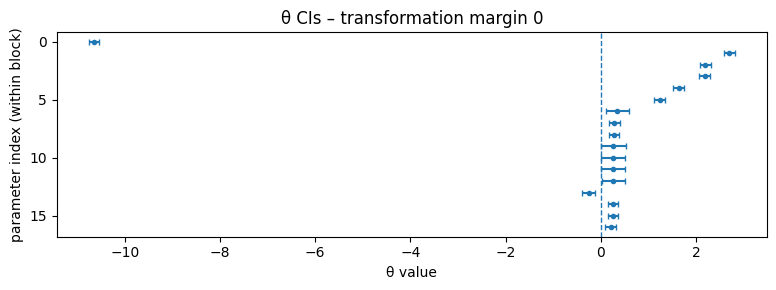

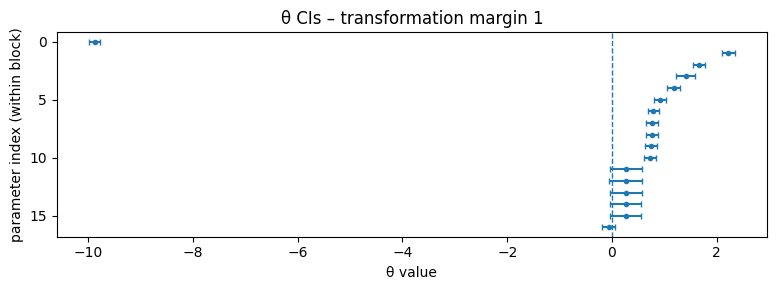

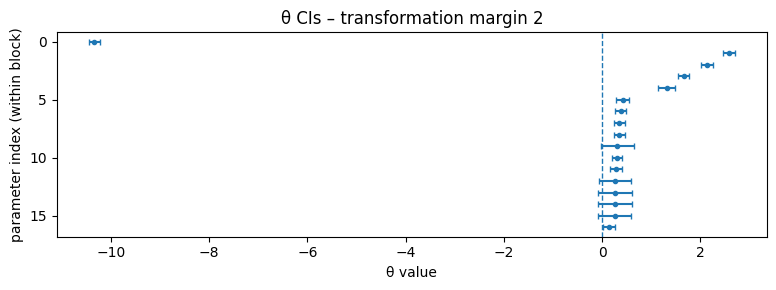

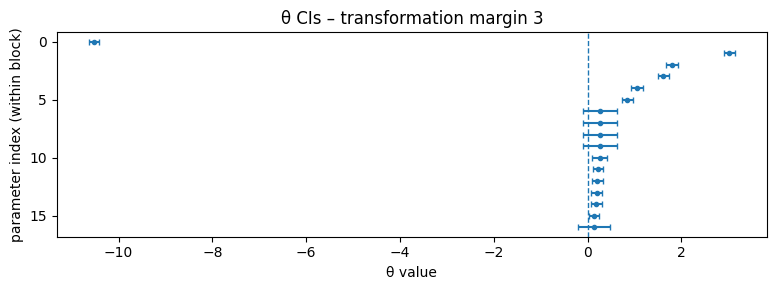

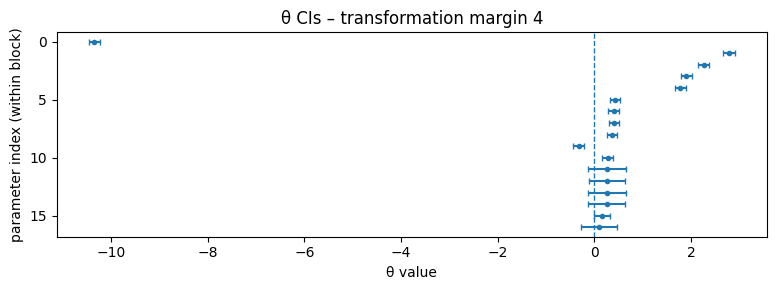

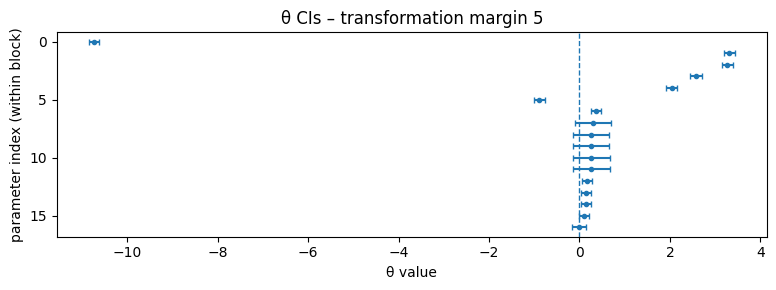

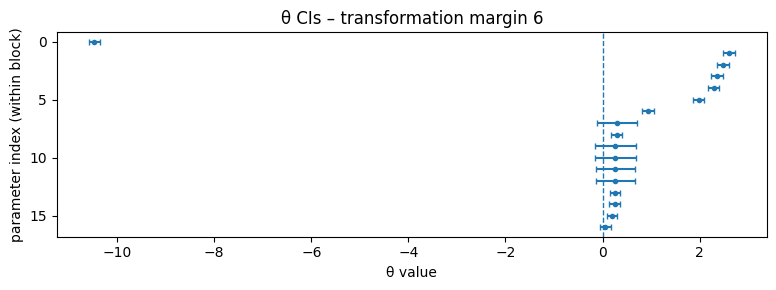

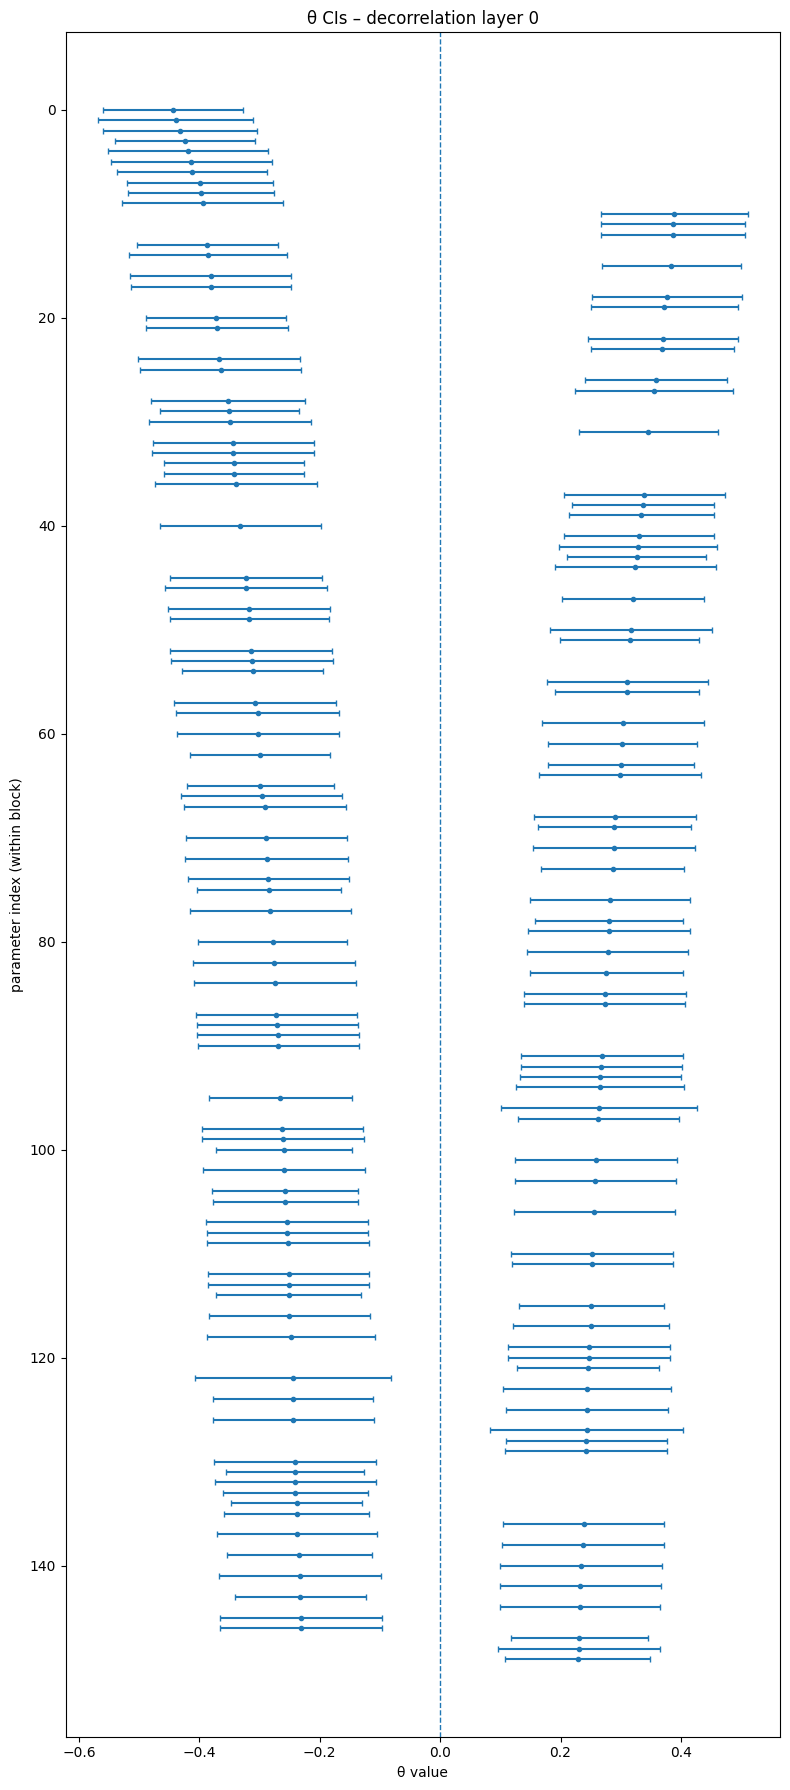

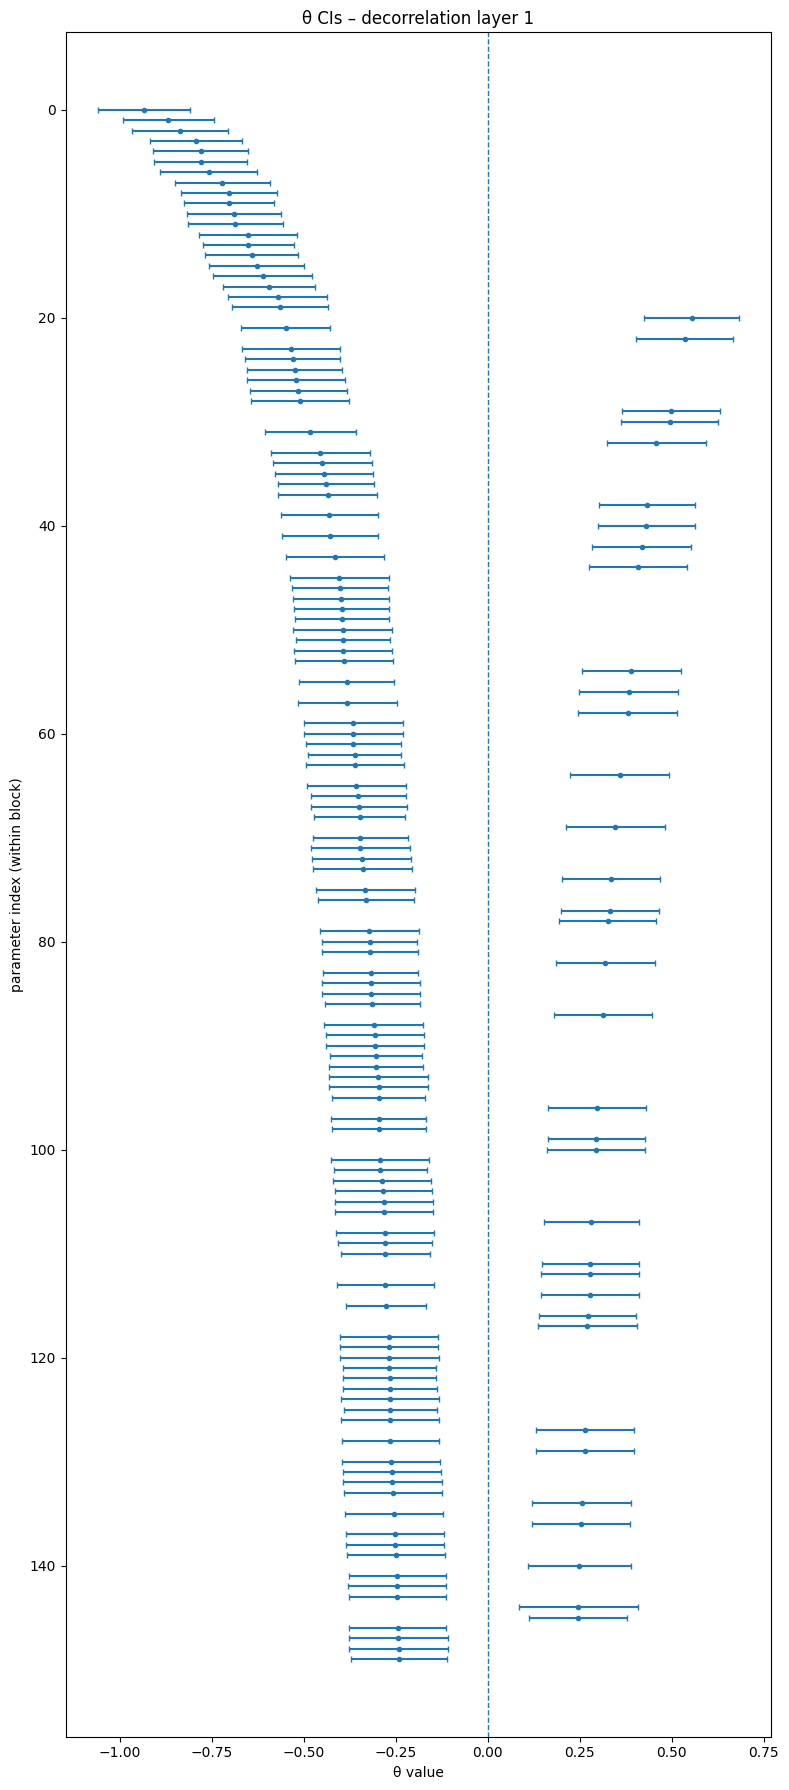

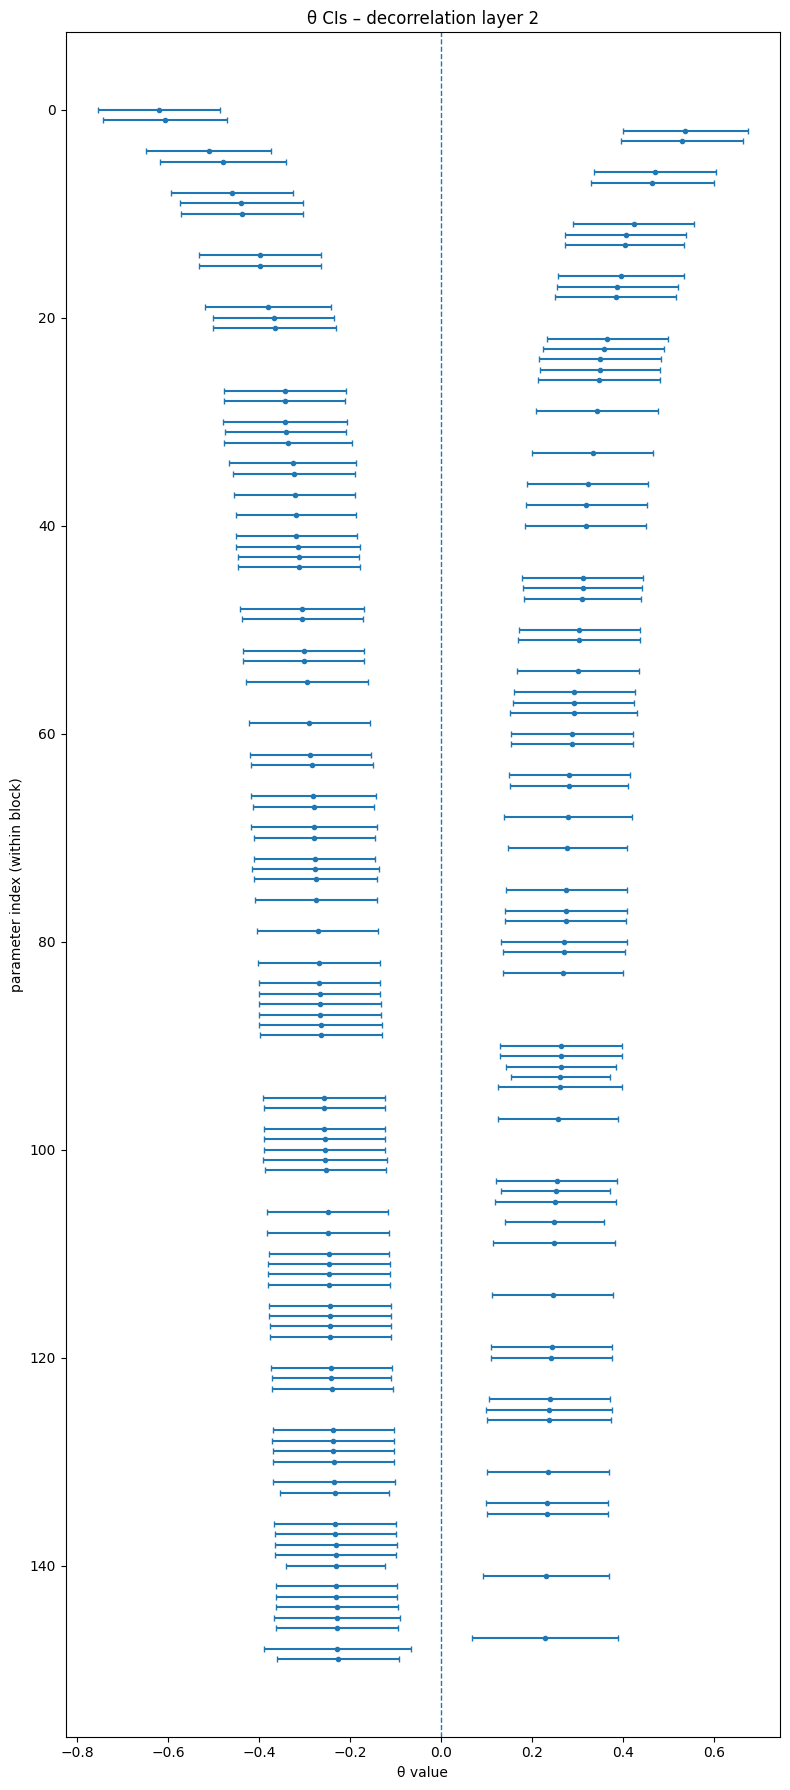

In [25]:
ci_blocks = theta_ci_by_schema(VI, level=0.95, sort_within_group=True)

# Transformation per margin
for j in range(7):
    key = f"transformation.params.{j}"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – transformation margin {j}", max_params=150)

# Decorrelation layers
for ℓ in range(3):
    key = f"decorrelation_layers.{ℓ}.params"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – decorrelation layer {ℓ}", max_params=150)


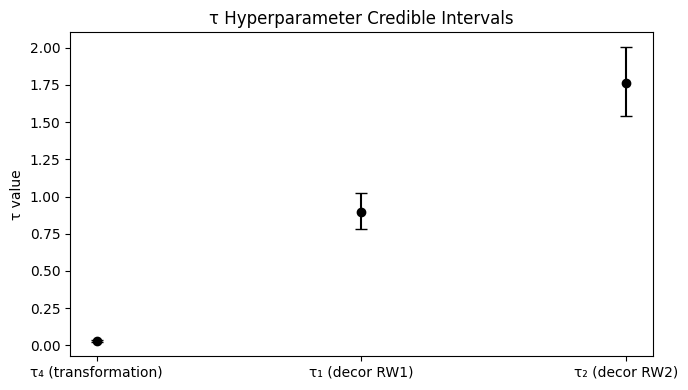

In [26]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [27]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


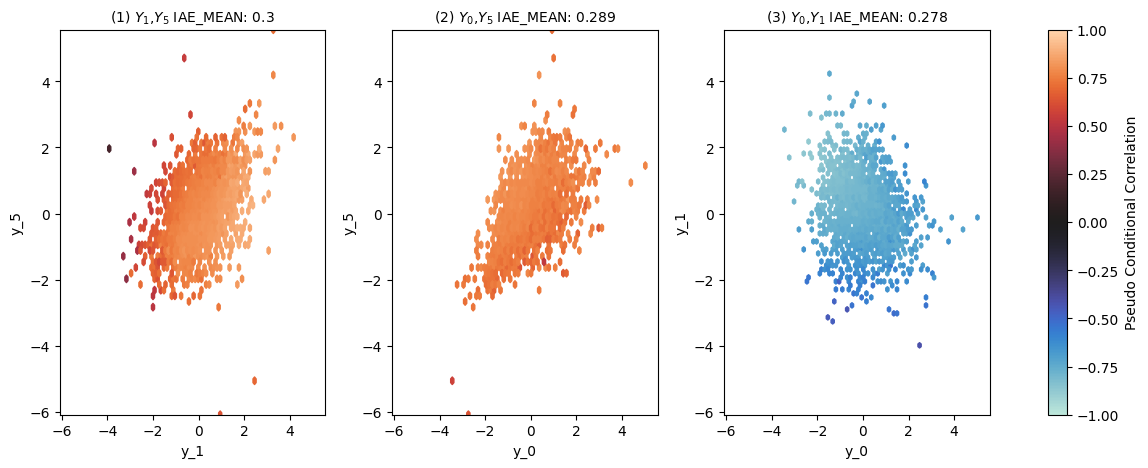

In [28]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

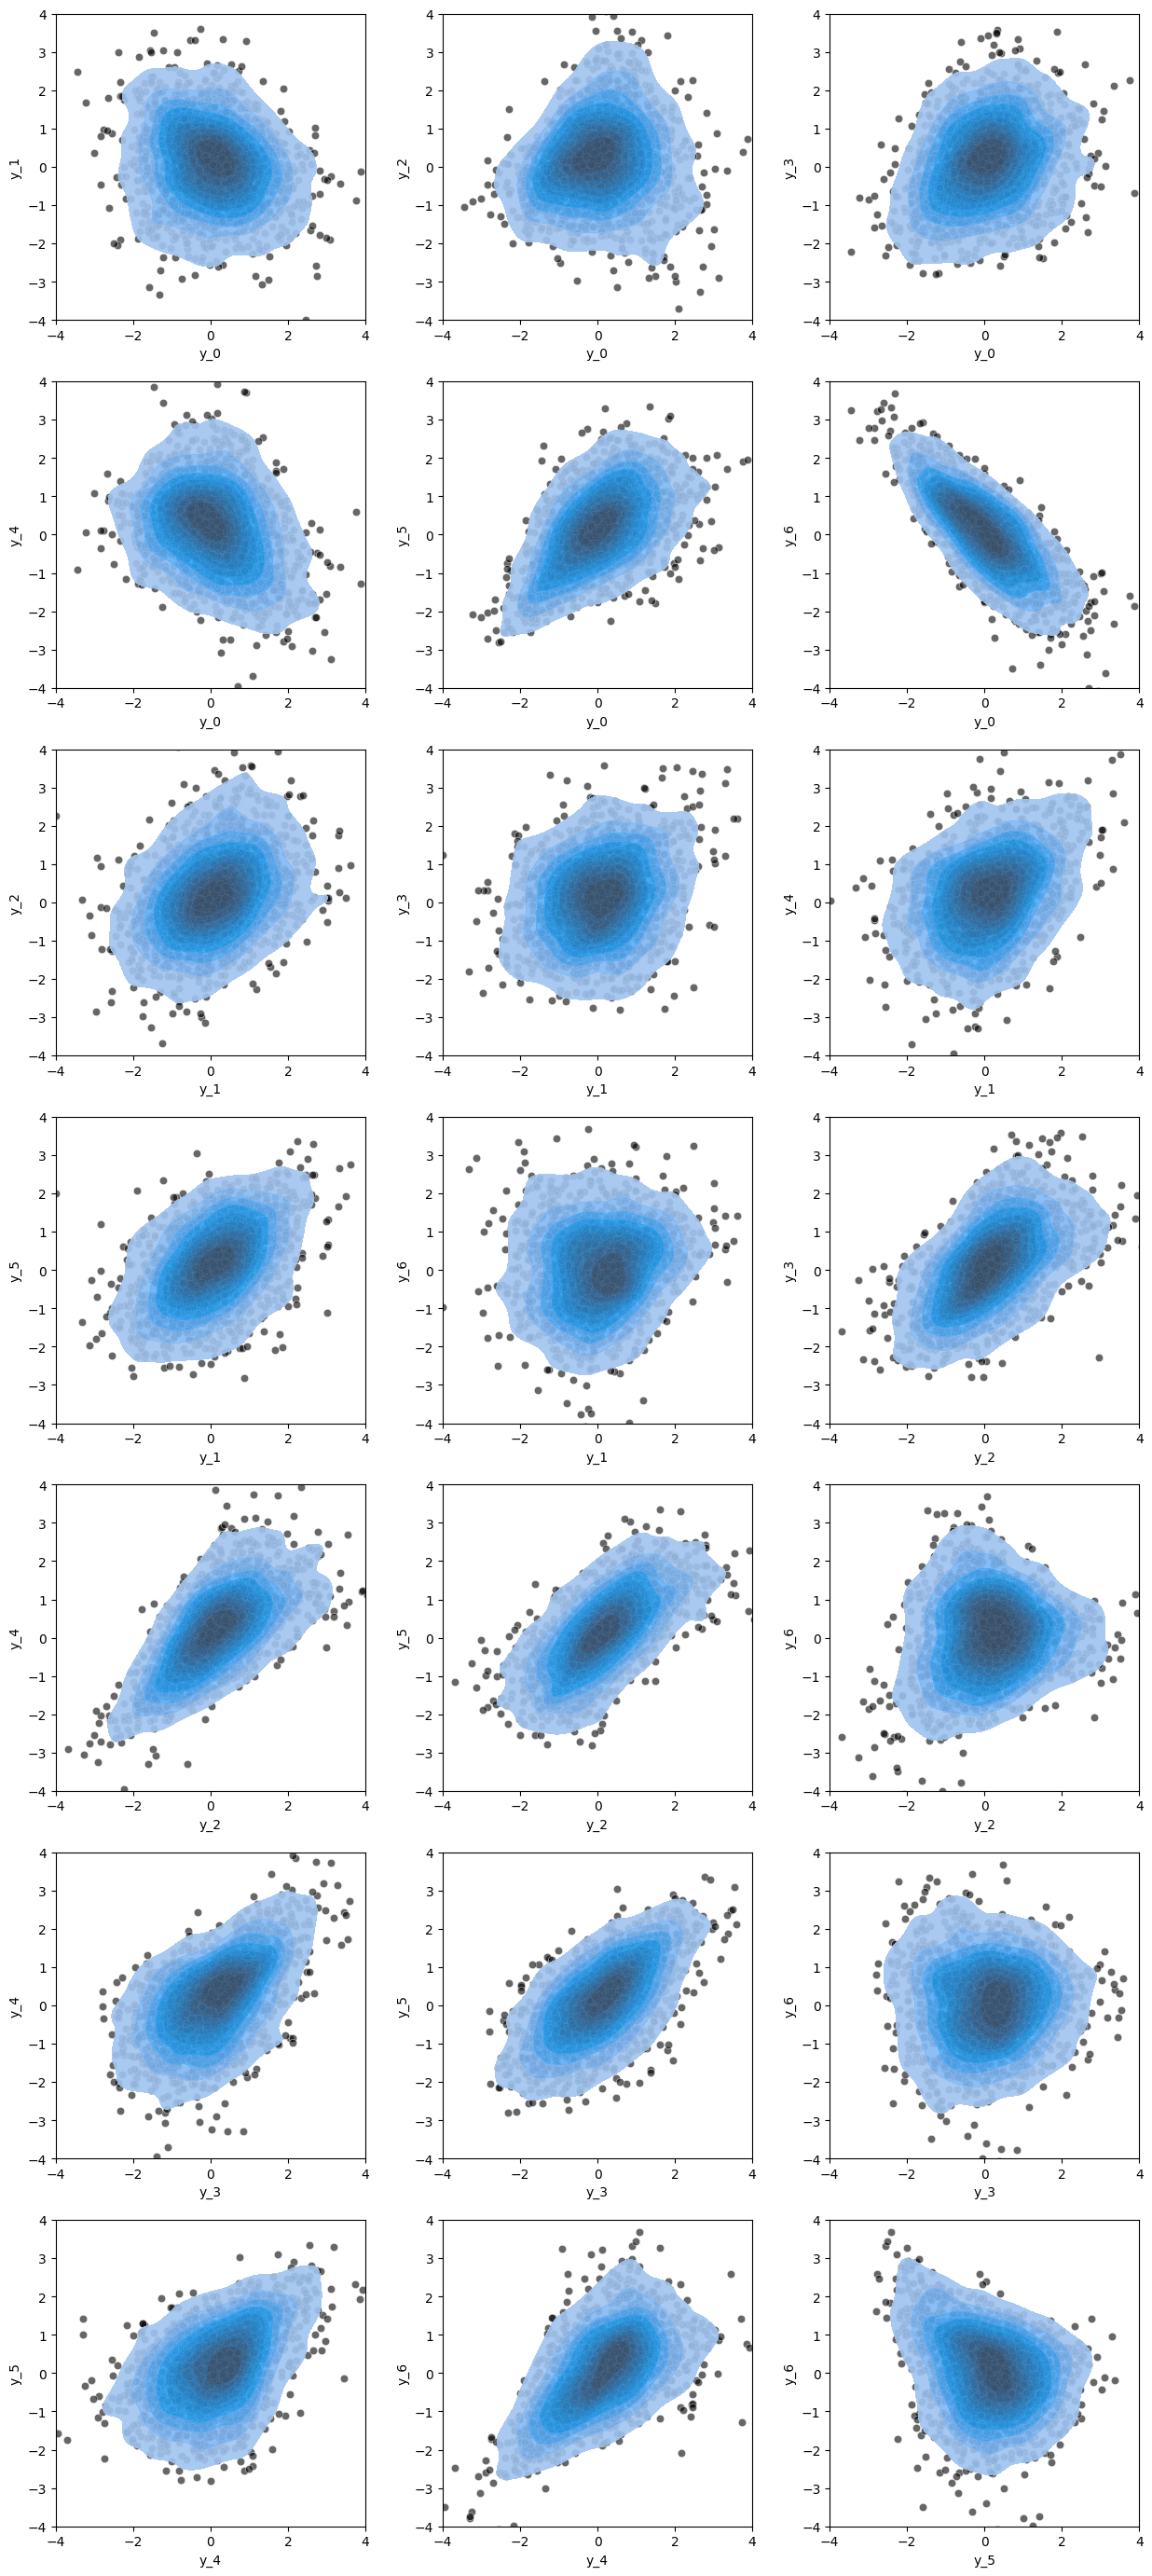

In [29]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [30]:
#model.plot_splines(layer_type="transformation")

In [31]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [32]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [33]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [34]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [35]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [39]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.977008,0.642034,-0.119481,-0.218182,-0.020779,-0.149351,-0.257143,-0.242857,-0.207792,...,-0.122078,-0.177922,-0.133766,-0.019481,-0.019481,-0.019481,-0.100000,-0.094805,-0.100000,0.078730
var_row,0.977008,1.000000,0.471429,-0.092384,-0.189420,-0.043866,-0.091055,-0.207365,-0.207365,-0.175463,...,-0.101689,-0.159512,-0.121628,-0.005982,-0.005982,-0.005982,-0.086402,-0.080420,-0.086402,-0.008058
var_col,0.642034,0.471429,1.000000,-0.203377,-0.317029,-0.008640,-0.347602,-0.392133,-0.355578,-0.326334,...,-0.176792,-0.192743,-0.141567,-0.091719,-0.091719,-0.091719,-0.138908,-0.138908,-0.138908,0.314271
abs_mean,-0.119481,-0.092384,-0.203377,1.000000,-0.246753,0.806494,-0.338961,-0.315584,-0.280519,-0.272727,...,0.985714,0.975325,0.976623,0.970130,0.970130,0.970130,0.983117,0.984416,0.983117,0.582599
mean,-0.218182,-0.189420,-0.317029,-0.246753,1.000000,-0.242857,0.924675,0.945455,0.972727,0.981818,...,-0.263636,-0.296104,-0.307792,-0.306494,-0.306494,-0.306494,-0.289610,-0.290909,-0.289610,-0.251935
std,-0.020779,-0.043866,-0.008640,0.806494,-0.242857,1.000000,-0.414286,-0.383117,-0.306494,-0.285714,...,0.807792,0.777922,0.803896,0.844156,0.844156,0.844156,0.841558,0.829870,0.841558,0.787296
min,-0.149351,-0.091055,-0.347602,-0.338961,0.924675,-0.414286,1.000000,0.984416,0.962338,0.957143,...,-0.342857,-0.357143,-0.383117,-0.375325,-0.375325,-0.375325,-0.387013,-0.385714,-0.387013,-0.425140
q_1,-0.257143,-0.207365,-0.392133,-0.315584,0.945455,-0.383117,0.984416,1.000000,0.985714,0.975325,...,-0.315584,-0.332468,-0.363636,-0.368831,-0.368831,-0.368831,-0.363636,-0.362338,-0.363636,-0.425140
q_5,-0.242857,-0.207365,-0.355578,-0.280519,0.972727,-0.306494,0.962338,0.985714,1.000000,0.996104,...,-0.285714,-0.302597,-0.332468,-0.341558,-0.341558,-0.341558,-0.325974,-0.324675,-0.325974,-0.362156
q_10,-0.207792,-0.175463,-0.326334,-0.272727,0.981818,-0.285714,0.957143,0.975325,0.996104,1.000000,...,-0.281818,-0.303896,-0.325974,-0.335065,-0.335065,-0.335065,-0.318182,-0.316883,-0.318182,-0.330664


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [37]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.8727272727272728
AUC KLD                    : 0.8909090909090909
AUC Conditional Correlation: 0.8545454545454545
AUC Precision Matrix       : 0.8363636363636364


We further print the ROC Curves for different metrics.

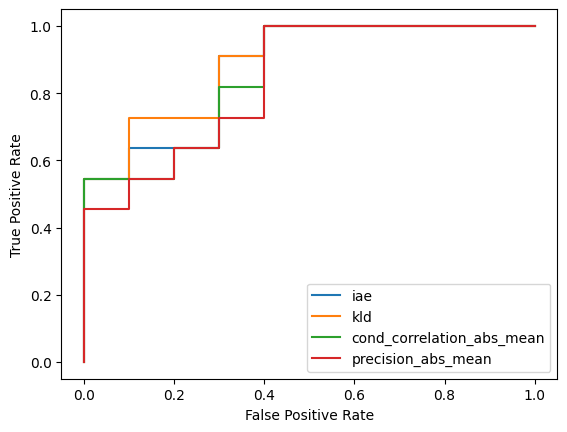

In [38]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()